In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import copy

import functions as f

In [2]:
text_1 = Image.open("text_1.jpg")
text_2 = Image.open("text_2.jpg")
text_1.load()
text_2.load()
text_1 = f.make_grey(text_1.resize(f.calc_size(text_1.size, 512)))
text_2 = f.make_grey(text_2.resize(f.calc_size(text_2.size, 512)))
print(np.array(text_1).shape)
print(np.array(text_2).shape)

images = [text_1, text_2]

(375, 512)
(406, 512)


In [3]:
def cummulative_summ(matrix):
    c_matrix = copy.copy(matrix)
    for i in range(1, len(matrix[0])):
        c_matrix[0][i] += c_matrix[0][i-1]
        c_matrix[i][0] += c_matrix[i-1][0]
    for i in range(1, len(matrix[0])):
        for j in range(1, len(matrix[0])):
            c_matrix[i][j] = c_matrix[i][j] + c_matrix[i - 1][j] + c_matrix[i][j - 1] - c_matrix[i - 1][j - 1]
    return c_matrix

In [4]:
def make_window(arr, i, j, d):
    wnd = []
    for k in np.arange(-d, d + 1):
        x = []
        for l in np.arange(-d, d + 1):
            x.append(arr[i + k][j + l])
        wnd.append(x)
    return wnd

In [5]:
def image_windows(img, a):
    d = int((a - 1) / 2)
    windows = []
    img_arr = np.array(img)
    img_arr_pad = np.pad(img_arr, (d, d), "edge")
    for i in range(d, len(img_arr_pad) - d):
        wnd_list = []
        for j in range(d, len(img_arr_pad[0]) - d):
            wnd = make_window(img_arr_pad, i, j, d)
            wnd_list.append(wnd)
        windows.append(wnd_list)
    return windows

In [6]:
def image_means(windows, a):
    means = []
    for wnd_list in windows:
        x = []
        for wnd in wnd_list:
            cs = cummulative_summ(wnd)
            x.append(cs[a - 1][a - 1] / a**2)
        means.append(x)
    return means

In [7]:
def image_sigmas(windows, img_means, a):
    sigmas = []
    img_means2 = image_means(np.square(windows), a)
    for (x1, x2)  in zip(img_means, img_means2):
        x = []
        for (y1, y2)  in zip(x1, x2):
            x.append(y2 - y1**2)
        sigmas.append(x)
    return sigmas

In [10]:
a = 7
curr_wnd = [image_windows(images[0], a), image_windows(images[1], a)]

In [11]:
blur_images = [image_means(curr_wnd[0], a), image_means(curr_wnd[1], a)]

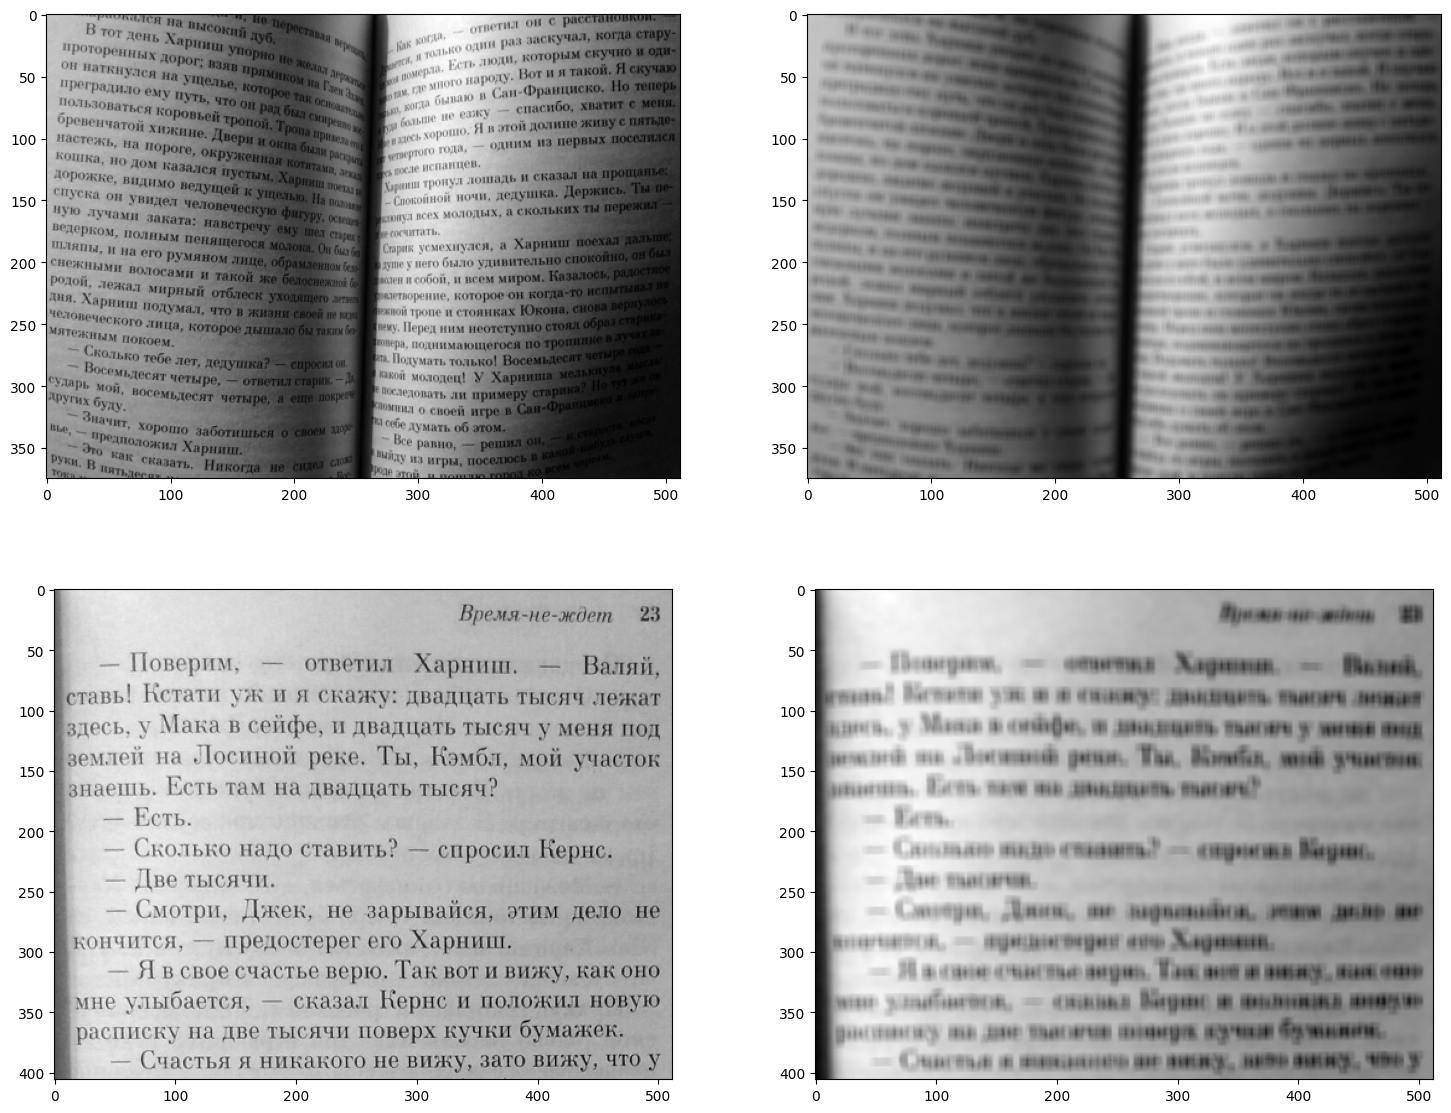

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(18, 14))
for i in range(2):
    ax[i][0].imshow(images[i], cmap="gray")
    ax[i][1].imshow(blur_images[i], cmap="gray")

In [19]:
curr_sigmas = [image_sigmas(curr_wnd[0], blur_images[0], a), image_sigmas(curr_wnd[1], blur_images[1], a)]

In [20]:
def cult_t_lb(img_means, img_sigmas, k):
    T = []
    for (m_list, s_list) in zip(img_means, img_sigmas):
        t = []
        for (m, s) in zip(m_list, s_list):
            t.append(m + k*np.sqrt(s))
        T.append(t)
    return T

In [44]:
k = [-0.0035, -0.005] 
curr_t_lb = [cult_t_lb(blur_images[0], curr_sigmas[0], k[0]), cult_t_lb(blur_images[1], curr_sigmas[1], k[1])]

In [45]:
def local_bin(img, t_lb):
    img_arr = np.array(img)
    img_lb = []
    for (x_list, t_list) in zip(img_arr, t_lb):
        img_lb.append(np.where(x_list <= t_list, 0, 255))
    return img_lb

In [46]:
bin_images = [local_bin(images[0], curr_t_lb[0]), local_bin(images[1], curr_t_lb[1])]

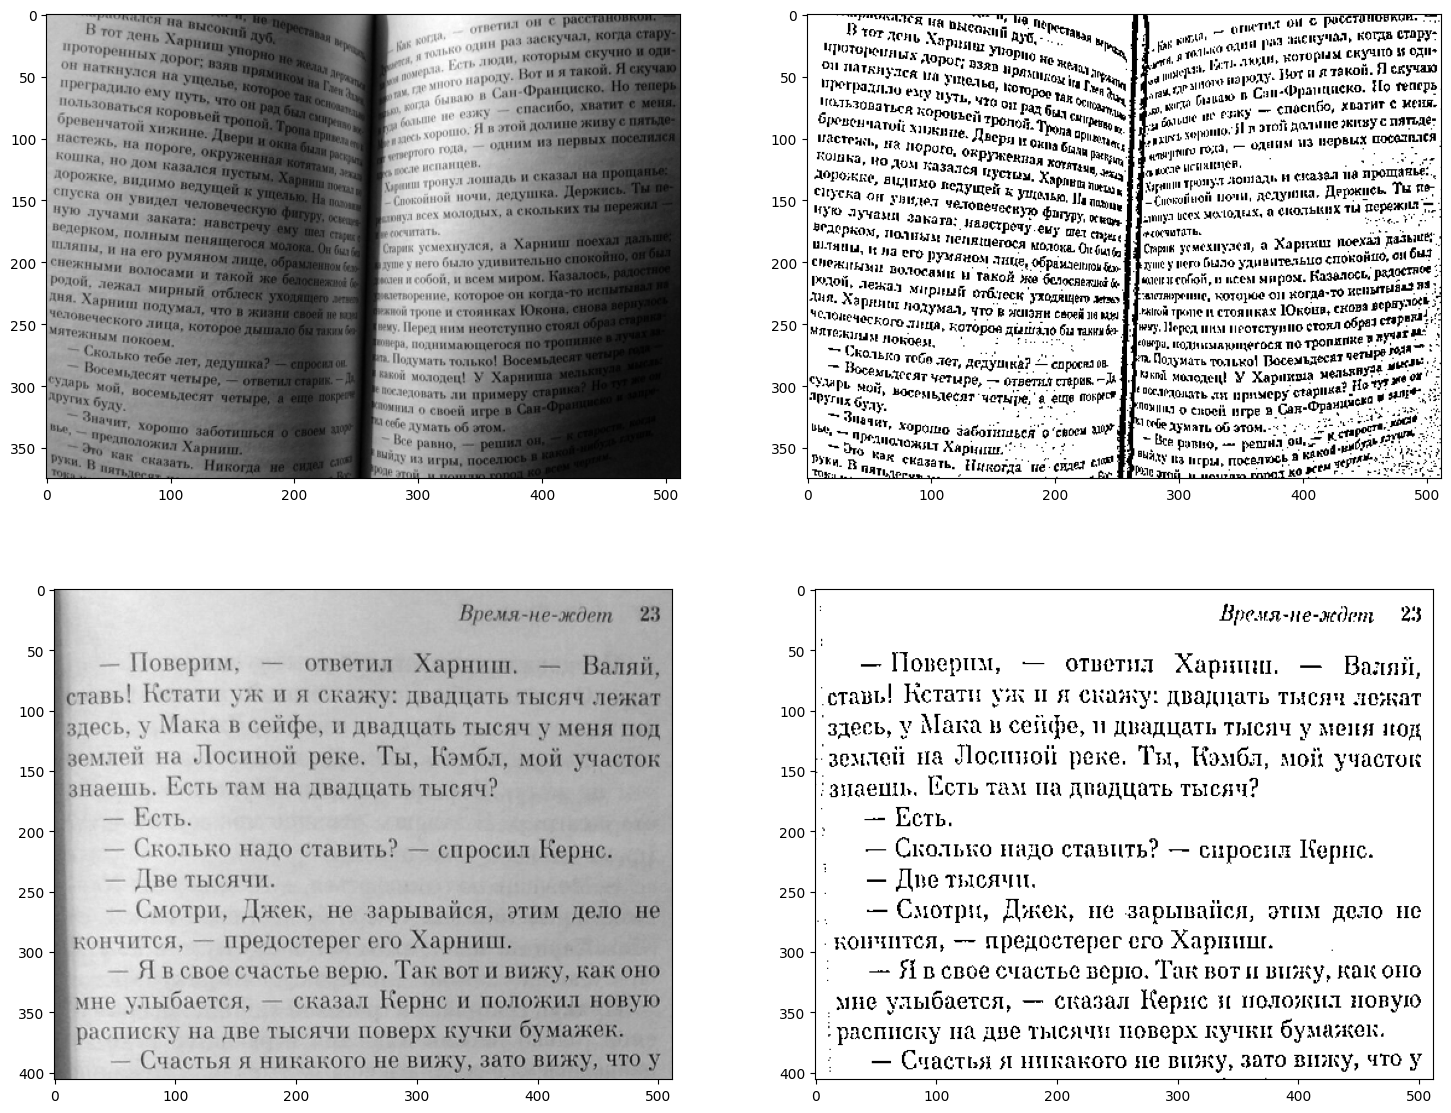

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(18, 14))
for i in range(2):
    ax[i][0].imshow(images[i], cmap="gray")
    ax[i][1].imshow(bin_images[i], cmap="gray")